In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.signal import convolve
from sklearn.decomposition import PCA

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter, landscape
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os
# Define the title for the entire PDF
pdf_title = "15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13"
# Define the base directory
base_dir = '/home/jwm/data/fluorescence_plots/'
# Construct the figure directory path
figure_dir = os.path.join(base_dir, pdf_title)
# Ensure the figure directory exists
os.makedirs(figure_dir, exist_ok=True)# Directory for joined pdfs
# Directory for joined pdfs
output_dir = '/home/jwm/data/fluorescence_plots/fluorescence_data_overview_21_may_2024/'
os.makedirs(output_dir, exist_ok=True)


In [2]:
## Load and organize data, set parameters and choose subset

# Set the directory where your data files are located
data_dir = '/home/jwm/data/JASCO_FP_6500_Spectrofluorometer/2024april19_50mM_DAB2_418_630_15mM_NaCl_1uMDCVJ_slow_hysteresis/'

# Set the number of the first and last spectrum to use in the plot -1
first_spectrum = 0
last_spectrum = 30

# Define the range of titles you want to load
start_title = 7
end_title = 30

titles = []

# Function to load (x, y) data from txt file starting from the 19th line
def load_data(file_path):
    return np.loadtxt(file_path, skiprows=18)

# Get all txt files in the directory
data_files = glob.glob(data_dir + "*.txt")

# Initialize a list to store loaded data
loaded_data = []

# Initialize variables for baseline data
baseline_data = None
baseline_title = None

# Load data from each file
for file_path in data_files:
    loaded_data.append(load_data(file_path))

# Extract 6th to 4th last digits from file name and use as title
titles = [int(file_path.split('/')[-1].split('.')[0][-7:-4]) for file_path in data_files]

# print(titles)

# Sort the titles and data_files in ascending order
sorted_indices = np.argsort(titles)
titles = [titles[i] for i in sorted_indices]
data_files = [data_files[i] for i in sorted_indices]
loaded_data = [loaded_data[i] for i in sorted_indices]

# Extract x-values from the first spectrum in loaded_data
wavelengths = loaded_data[0][2:, 0].astype(float)
    
# Check if file name contains "999" and assign it as baseline data
if "999" in file_path:
    baseline_data = loaded_data[-1]
    baseline_title = title

# Sort the files by their title
data_files.sort(key=lambda x: int(x.split('/')[-1].split('.')[0][-6:-4]))

print(titles)
# print(loaded_data)

# Convert extracted digits back to temperature values
temperatures = [10 + i * 0.5 for i in range(len(titles))]


# Sample loaded_data structure
# loaded_data = [
#    np.array([[470.0, 422.133], [470.1, 422.08], [470.2, 422.001], [650.0, 7.49391]]),
#    np.array([[470.0, 430.678], [470.1, 430.75], [470.2, 430.611], [650.0, 7.97855]])
#]

# Function to create DataFrame
def create_dataframe(loaded_data, titles):  # spectra in rows
    # Initialize DataFrame with the first spectrum
    df = pd.DataFrame(loaded_data[0], columns=['wavelength', titles[0]])
    
    # Iterate over the remaining spectra and concatenate them to the DataFrame
    for i in range(1, len(loaded_data)):
        spectrum_df = pd.DataFrame(loaded_data[i], columns=['wavelength', titles[i]])
        df = pd.merge(df, spectrum_df, on='wavelength', how='outer')
    
    return df

# Example usage
# included_titles = [int(title) for title in input("Enter the titles to include (separated by space): ").split()]
# selected_data = [loaded_data[titles.index(title)] for title in included_titles]

title_inputs = input("Enter the titles to include (separated by space), and ranges separated by '-': ").split()
included_titles = [title for title_input in title_inputs for title in (list(range(int(title_input.split('-')[0]), int(title_input.split('-')[-1])+1)) if '-' in title_input else [int(title_input)])]

def get_selected_data(loaded_data, titles_input):
    selected_data = []
    selected_temperatures = []
    for title_input in titles_input:
        if '-' in str(title_input):
            start, end = map(int, title_input.split('-'))
            selected_data.extend(loaded_data[start-1:end])
            selected_temperatures.extend(temperatures[start-1:end])
        else:
            selected_data.append(loaded_data[int(title_input)-1])
            selected_temperatures.append(temperatures[int(title_input)-1])
    return selected_data, selected_temperatures
    
selected_data, selected_temperatures = get_selected_data(loaded_data, included_titles)

df = create_dataframe(selected_data, included_titles)
df = df.transpose()
print(df)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 999]


Enter the titles to include (separated by space), and ranges separated by '-':  1-45


               0        1        2        3        4        5        6     \
wavelength  460.000  460.100  460.200  460.300  460.400  460.500  460.600   
1           999.999  999.999  999.999  999.999  999.999  999.999  999.999   
2           881.478  876.608  871.525  865.490  859.399  852.070  844.697   
3           513.685  510.724  507.318  503.640  499.245  494.811  490.619   
4           449.152  446.428  443.569  441.276  437.531  433.451  430.469   
5           478.635  475.606  472.560  468.919  465.793  461.620  458.219   
6           479.518  476.302  473.639  470.418  466.705  462.785  459.156   
7           483.113  480.880  478.080  474.836  470.936  467.942  464.665   
8           521.923  518.642  516.154  512.834  508.432  504.843  501.116   
9           545.570  542.362  538.933  535.293  531.342  527.278  522.796   
10          607.929  604.926  601.147  597.488  592.803  587.565  582.053   
11          633.125  629.457  624.493  619.870  615.604  610.397  605.156   

[9.16194942e-01 8.31083104e-02 3.87469344e-04]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/3_components_with_explained_variances.svg


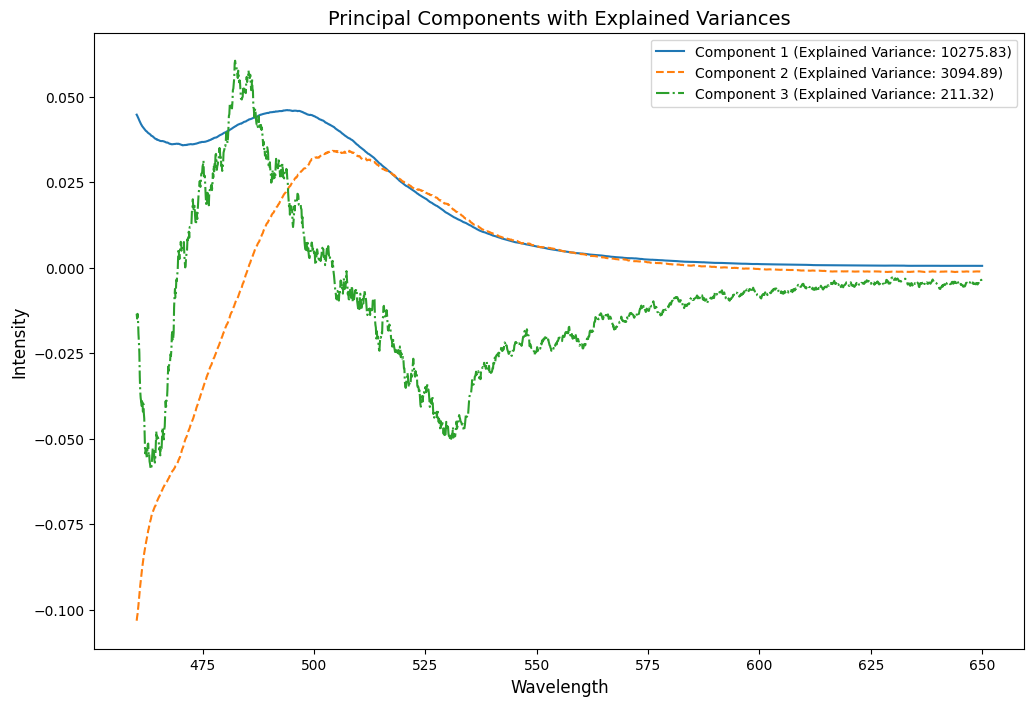

[[ 0.0447813   0.04454813  0.0442772  ...  0.00054744  0.00053801
   0.00055336]
 [-0.10327341 -0.10212859 -0.10129702 ... -0.00108898 -0.00111262
  -0.0011104 ]
 [-0.01346984 -0.01487129 -0.01349474 ... -0.0035249  -0.00393364
  -0.0037469 ]]
[460.2 460.3 460.4 ... 649.8 649.9 650. ]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/4_component_scaling_factor_time_course.svg


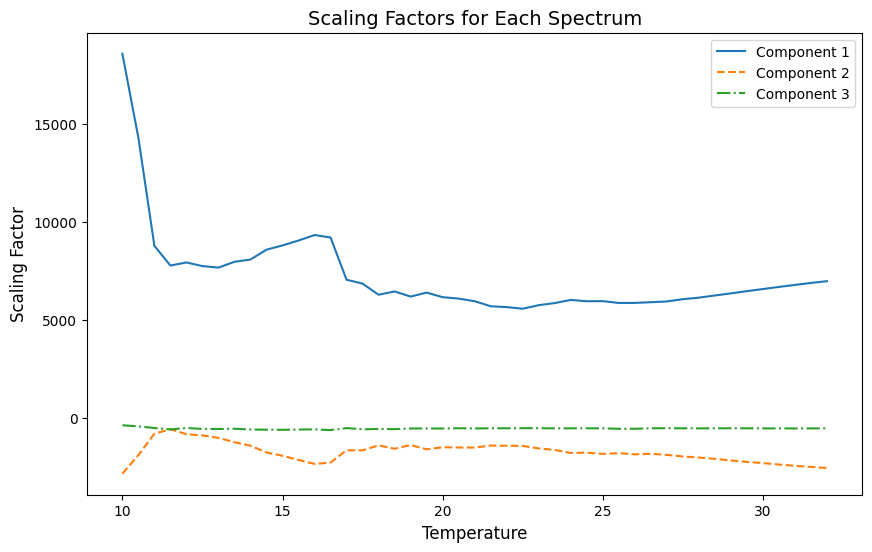

Explained variance in selected data for each component after rotation: [0.00291541 0.9426275  0.05337633]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/5_smoothed_rotated_components_with_explained_variances.svg


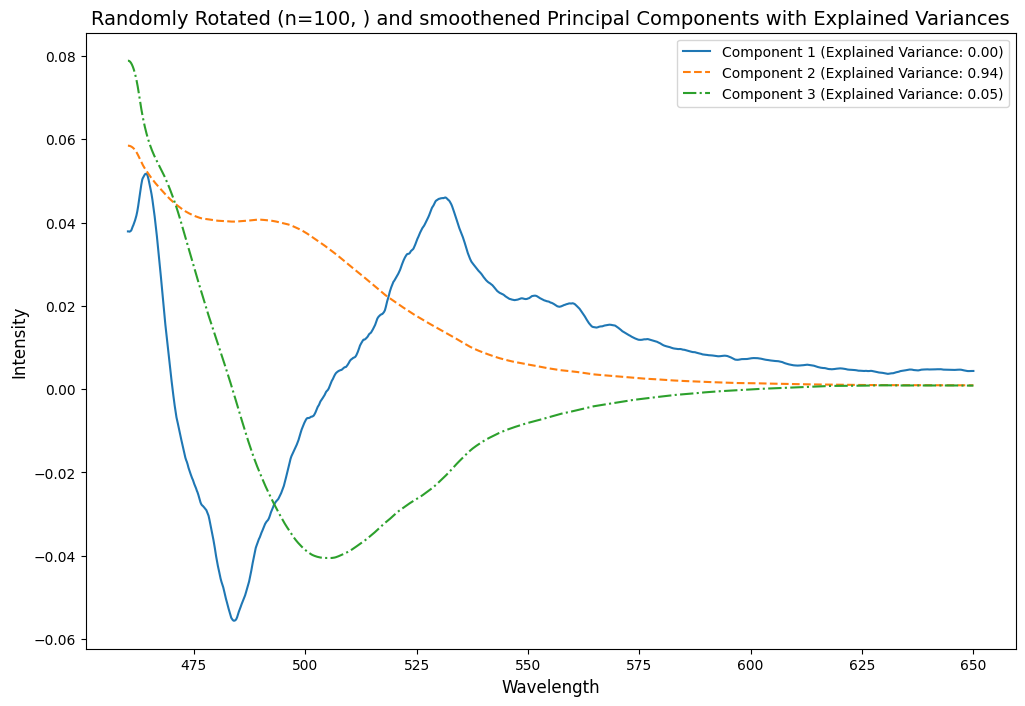

Best rotation is: [[0.03789063 0.03789063 0.03785392 ... 0.00435735 0.00436029 0.00437107]
 [0.05847527 0.05847527 0.05846397 ... 0.00092397 0.0009239  0.00092429]
 [0.0788786  0.0788786  0.07884965 ... 0.00085997 0.00086004 0.0008592 ]]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/6_smoothed_rotated_component_scaling_factor_time_course.svg


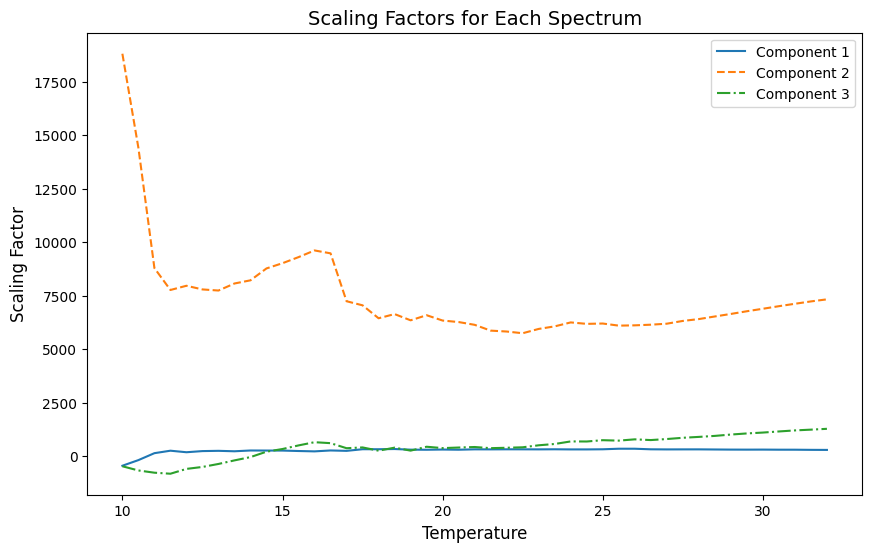

<module 'matplotlib.pyplot' from '/home/jwm/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [5]:
## Perform initial PCA

n_components=3

# Define the line styles to be used
line_styles = ['-', '--', '-.', ':']


# Extract spectra and wavelengths
spectra = df.iloc[1:, 2:].values.astype(float)  # Convert to numpy array
# wavelengths = df.iloc[1, 2:].values.astype(float)
# wavelengths = df.columns[2:].astype(float)

def perform_pca(df, n_components):
    # Extracting the spectra data from the DataFrame
    spectra = df.values[2:, 2:]
    
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    
    # Fit PCA to the spectra data
    pca.fit(spectra)
    
    # Get the explained variance ratio and singular values
    explained_variance_ratio = pca.explained_variance_ratio_
    singular_values = pca.singular_values_
    components = pca.components_
    
    return explained_variance_ratio, singular_values, components


explained_variance_ratio, singular_values, components = perform_pca(df, n_components)

print(explained_variance_ratio)


# Project components onto each spectrum
    
def calculate_scaling_factors(df, n_components, components):
    # Initialize scaling factors list
    scaling_factors = []
    max_length = 0
    
    for spectrum in spectra:
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(components.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors)):
        scaling_factors[i] = np.pad(scaling_factors[i], (0, max_length - len(scaling_factors[i])), 'constant')
    
    return np.array(scaling_factors)



scaling_factors = calculate_scaling_factors(df, n_components, components)
# print(scaling_factors)


# Plots calculated components

def plot_components_with_explained_variances(components, explained_variance, wavelengths):
    plt.figure(figsize=(12, 8))
    for i, component in enumerate(components):
        plt.plot(wavelengths, component, line_styles[i % len(line_styles)],  label=f'Component {i+1} (Explained Variance: {explained_variance[i]:.2f})')

    plt.xlabel('Wavelength', fontsize=12)
    plt.ylabel('Intensity', fontsize=12)
    plt.title('Principal Components with Explained Variances', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, '3_components_with_explained_variances.svg')
    print(save_path)
    plt.savefig(save_path)    
    plt.show()
    return plt


plot_components_with_explained_variances(components, singular_values, wavelengths)

print(components)
print(wavelengths)


# Plots scaling factors for components for chosen spectra

def plot_scaling_factors(scaling_factors, selected_temperatures, n_components):
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        scaling_factor_values = [factor[i] for factor in scaling_factors]
        plt.plot(selected_temperatures, scaling_factor_values, line_styles[i % len(line_styles)],  label=f'Component {i+1}')

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Scaling Factor', fontsize=12)
    plt.title('Scaling Factors for Each Spectrum', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, '4_component_scaling_factor_time_course.svg')
    print(save_path)
    plt.savefig(save_path)   
    plt.show()
    return plt

# Example usage:
plot_scaling_factors(scaling_factors, selected_temperatures, n_components)




## Rotate randomly and smoothen, accept if total error over all spectra is diminished

def smooth_components(components, window_length=50):
    smoothed_components = np.apply_along_axis(
        lambda x: moving_average(x, window_length), axis=1, arr=components)
    return smoothed_components


def moving_average(x, window_length):
    # Extend the signal using mirroring to handle boundary effects
    extended_x = np.pad(x, (window_length//2, window_length//2), mode='reflect')
    
    # Create a rectangular window of ones
    window = np.ones(window_length) / window_length
    
    # Perform convolution of extended_x with the window to compute the moving average
    smoothed_x = np.convolve(extended_x, window, mode='valid')
    
    # Return the central portion corresponding to the original length of x
    start_idx = (smoothed_x.shape[0] - x.shape[0]) // 2
    end_idx = start_idx + x.shape[0]
    return smoothed_x[start_idx:end_idx]

def calculate_scaling_factors_rotated(df, n_components, best_rotation, window_length=50):
    # Smooth the rotated components
    smoothed_components = smooth_components(best_rotation, window_length)

    # Initialize scaling factors list
    scaling_factors_rotated = []
    max_length = 0
    
    for spectrum in df.to_numpy():
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(smoothed_components.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors_rotated.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors_rotated)):
        scaling_factors_rotated[i] = np.pad(scaling_factors_rotated[i], (0, max_length - len(scaling_factors_rotated[i])), 'constant')
    
    return np.array(scaling_factors_rotated)


def random_rotation(components):
    q, _ = np.linalg.qr(np.random.randn(*components.shape))
    return q

def calculate_reconstruction_error(rotated_components, spectra, window_length=50):
    smoothed_components = smooth_components(rotated_components, window_length)

    def objective(x):
        return np.sum((spectrum - np.dot(smoothed_components.T, x))**2)

    total_error = 0
    for spectrum in spectra:
        x0 = np.ones(rotated_components.shape[0])
        res = minimize(objective, x0)
        total_error += np.sum((spectrum - np.dot(smoothed_components.T, res.x))**2)

#    print("Smoothed components:", smoothed_components)
#    print("Total error:", total_error)
    
    return total_error, smoothed_components
    

def find_best_rotation(components, spectra, n_rotations=50, window_length=50):
    best_rotation = None
    min_error = float('inf')
    
    for _ in range(n_rotations):
        rotation_matrix = random_rotation(components)
        rotated_components = np.dot(rotation_matrix, components)
        
        total_error, smoothed_components = calculate_reconstruction_error(rotated_components, spectra, window_length)
        
        if total_error < min_error:
            min_error = total_error
            best_rotation = smoothed_components
    
    return best_rotation

n_rotations = 100
best_rotation = find_best_rotation(components, spectra)


    


def calculate_explained_variance(df, best_rotation):
    # Extract spectra from the DataFrame
    spectra = df.iloc[1:, 2:].values.astype(float)
    
    # Compute the covariance matrix of the spectra
    cov_matrix = np.cov(spectra, rowvar=False)
    
    # Calculate the total variance of the spectra
    total_variance = np.trace(cov_matrix)
    
    # Compute the variance explained by each component in the best rotation matrix
    component_variances = np.diag(np.dot(np.dot(best_rotation, cov_matrix), best_rotation.T))
    
    # Normalize the explained variance by dividing by the total variance
    explained_variance_rotated = component_variances / total_variance
    
    return explained_variance_rotated

explained_variance_rotated = calculate_explained_variance(df, best_rotation)
print("Explained variance in selected data for each component after rotation:", explained_variance_rotated)


def calculate_scaling_factors_rotated(df, n_components, best_rotation):
    # Initialize scaling factors list
    scaling_factors_rotated = []
    max_length = 0
    
    for spectrum in spectra:
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(best_rotation.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors_rotated.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors_rotated)):
        scaling_factors_rotated[i] = np.pad(scaling_factors_rotated[i], (0, max_length - len(scaling_factors_rotated[i])), 'constant')
    
    return np.array(scaling_factors_rotated)


# Plots final(lowest residue) smoothened rotated components

def plot_rotated_components_with_explained_variances(best_rotation, explained_variance_rotated, wavelengths):
    plt.figure(figsize=(12, 8))
    for i, component in enumerate(best_rotation):
        plt.plot(wavelengths, component, line_styles[i % len(line_styles)],  label=f'Component {i+1} (Explained Variance: {explained_variance_rotated[i]:.2f})')

    plt.xlabel('Wavelength', fontsize=12)
    plt.ylabel('Intensity', fontsize=12)
    plt.title(f'Randomly Rotated (n={n_rotations}, ) and smoothened Principal Components with Explained Variances', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, '5_smoothed_rotated_components_with_explained_variances.svg')
    print(save_path)
    plt.savefig(save_path)    
    plt.show()
    return plt


plot_rotated_components_with_explained_variances(best_rotation, explained_variance_rotated, wavelengths)

print("Best rotation is:", best_rotation)



# Plots scaling factors for smoothened rotated components for chosen spectra

def plot_scaling_factors_rotated(scaling_factors_rotated, selected_temperatures, n_components):
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        scaling_factor_rotated_values = [factor[i] for factor in scaling_factors_rotated]
        plt.plot(selected_temperatures, scaling_factor_rotated_values, line_styles[i % len(line_styles)], label=f'Component {i+1}')

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Scaling Factor', fontsize=12)
    plt.title('Scaling Factors for Each Spectrum', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, '6_smoothed_rotated_component_scaling_factor_time_course.svg')
    print(save_path)
    plt.savefig(save_path)   
    plt.show()
    return plt


scaling_factors_rotated = calculate_scaling_factors_rotated(df, n_components, best_rotation)
plot_scaling_factors_rotated(scaling_factors_rotated, selected_temperatures, n_components)





/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/7_difference_between_spectrum_and_sum_scaled_components.svg


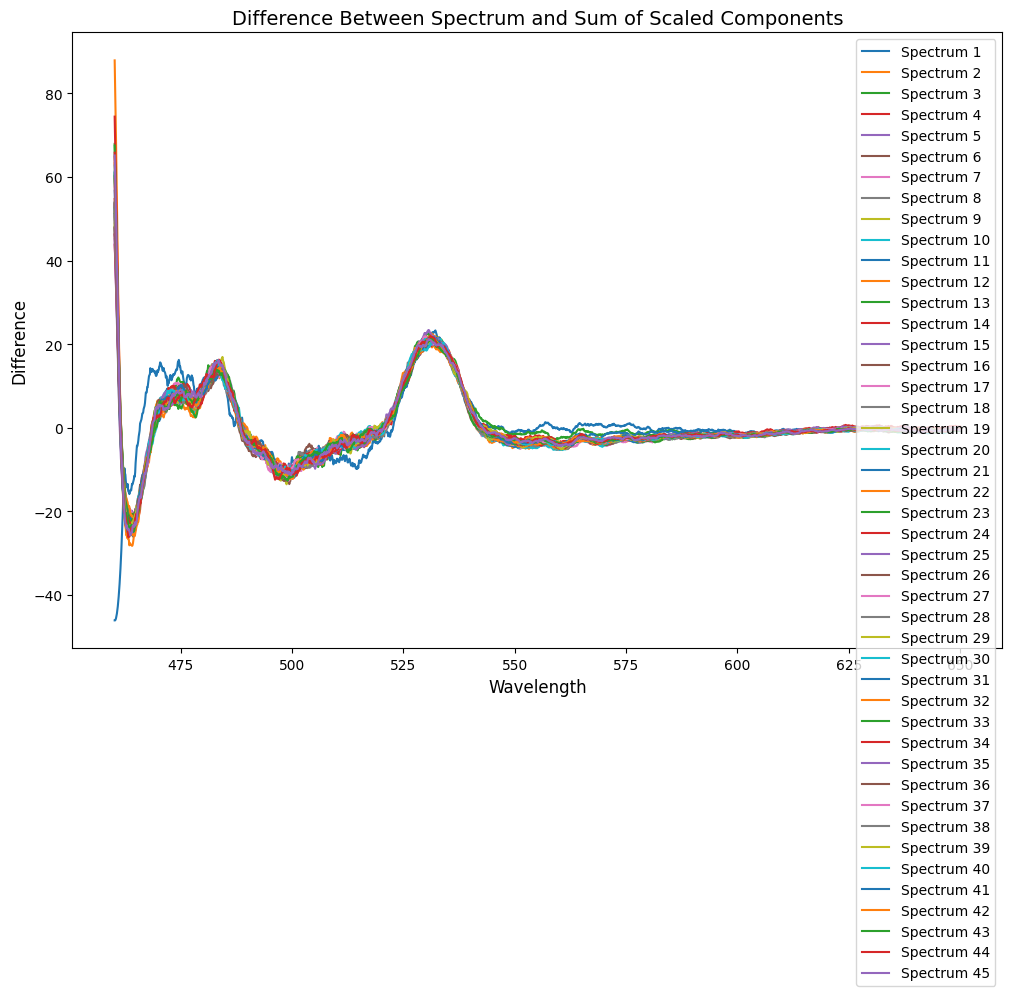

In [6]:
# Define a function to calculate the sum of scaled components for each spectrum
def calculate_sum_scaled_components(best_rotation, scaling_factors_rotated):
    sum_rotated_components = []
    for scaling_factor in scaling_factors_rotated:
        sum_scaled = np.dot(best_rotation.T, scaling_factor)
        sum_rotated_components.append(sum_scaled)
    return np.array(sum_rotated_components)

# Calculate sum of scaled components
sum_rotated_components = calculate_sum_scaled_components(best_rotation, scaling_factors_rotated)

# Calculate the difference between each spectrum and the sum of scaled components
differences = spectra - sum_rotated_components

# Plotting the differences for all spectra in one plot
plt.figure(figsize=(12, 8))
for i in range(len(differences)):
    plt.plot(wavelengths, differences[i], label=f'Spectrum {i+1}')

plt.xlabel('Wavelength', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Difference Between Spectrum and Sum of Scaled Components', fontsize=14)
plt.legend()
plt.grid(False)
save_path = os.path.join(figure_dir, '7_difference_between_spectrum_and_sum_scaled_components.svg')
print(save_path)
plt.savefig(save_path)    
plt.show()